# Phase 1: Static ASL Training & Ablations

### Imports

In [15]:
# Standard PyTorch + Torchvision stack
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score

# Reproducibility (essential for research and debugging)
import random
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Note: For complete reproducibility, you may also need:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Device (GPU if available)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

# Loading data
import numpy as np
import kagglehub
import os
from sklearn.model_selection import train_test_split

Using device: cpu


### ResNet-18

In [3]:
# Load ResNet-18
res18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

### Preprocessing

In [4]:
# ImageNet channel-wise statistics (computed over millions of images)
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Mean per channel (R, G, B)
IMAGENET_STD  = [0.229, 0.224, 0.225]  # Std dev per channel

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 64
SEED = 429
LIMIT_PER_CLASS = 5

# Download data
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
data_dir = os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")

# Training transforms
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Validation transforms
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Load dataset
raw_dataset = datasets.ImageFolder(root=data_dir) 

# 5 images per class
indices_to_use = []
targets = np.array(raw_dataset.targets)
classes = np.unique(targets)

for cls in classes:
    cls_indices = np.where(targets == cls)[0]
    indices_to_use.extend(cls_indices[:LIMIT_PER_CLASS])

# Get labels
subset_labels = targets[indices_to_use]

# 80/20 split
train_idx, val_idx = train_test_split(
    indices_to_use, 
    test_size=0.2, 
    stratify=subset_labels, 
    random_state=SEED
)

train_source = datasets.ImageFolder(root=data_dir, transform=train_tf)
val_source   = datasets.ImageFolder(root=data_dir, transform=val_tf)

# Final subsets
full_train_source = datasets.ImageFolder(root=data_dir, transform=train_tf)
full_val_source   = datasets.ImageFolder(root=data_dir, transform=val_tf)

train_ds = Subset(full_train_source, train_idx)
val_ds   = Subset(full_val_source, val_idx)

train_ds.classes = train_source.classes
val_ds.classes = val_source.classes

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

NUM_CLASSES = 29
print(f' Dataset: {len(train_ds):,} train, {len(val_ds):,} val')
print(f' Classes: {train_ds.classes}')

 Dataset: 116 train, 29 val
 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


### Adapt ResNet-18 for ASL

In [6]:
# Start with ImageNet-pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Examine the original classifier
print(" Original FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (ImageNet classes)")

# Replace with our custom classifier
# The in_features must match (512 for ResNet-18's final feature size)
# The NUM_CLASSES will change for other datasets
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

print("\n New FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (our classes)")

# Move model to GPU if available
model = model.to(DEVICE)

 Original FC layer:
  Input features: 512
  Output features: 1000 (ImageNet classes)

 New FC layer:
  Input features: 512
  Output features: 29 (our classes)


### Freezing and Unfreezing

In [8]:
def set_requires_grad(module: nn.Module, requires_grad: bool):
    """
    Recursively set requires_grad for all parameters in a module.
    
    Args:
        module: PyTorch module (layer, block, or entire model)
        requires_grad: True to unfreeze (train), False to freeze
    """
    for param in module.parameters():
        param.requires_grad = requires_grad
    
    # Print status
    param_count = sum(p.numel() for p in module.parameters())
    status = "UNFROZEN (trainable)" if requires_grad else "FROZEN"
    print(f"  {module.__class__.__name__}: {param_count:,} parameters {status}")

### Training and Evaluation Functions

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    """
    Train for one epoch.
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()  # Enable dropout, batch norm training mode
    
    total_samples = 0
    correct_predictions = 0
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device (GPU/CPU)
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        logits = model(images)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        
        # Track metrics
        running_loss += loss.item() * images.size(0)
        predictions = logits.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += images.size(0)
        
        # Optional: Print progress
        if batch_idx % 100 == 0:
            print(f"    Batch {batch_idx}/{len(loader)}, "
                  f"Loss: {loss.item():.4f}")
    
    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

### Model Training

#### Grid Search Setup

In [21]:
# --- Fixed Epochs and Grid Search Space ---
# Using 3 epochs as the fixed value based on your previous runs.
FIXED_EPOCHS = 3 

GRID_SEARCH_SPACE_LR_ONLY = {
    # T-A: Phase 1.1 (Head Only)
    "T-A": {"LRs": [1e-3, 5e-4, 1e-4, 5e-5]},
    # T-B: Phase 1.2 (Layer 4 + Head)
    "T-B": {"LRs": [1e-4, 5e-5, 1e-5, 5e-6]},
    # T-C: Phase 1.3 (Layer 3 + Layer 4 + Head)
    "T-C": {"LRs": [1e-5, 5e-6, 1e-6, 5e-7]},
    # S-A: Phase 1.4 (Full Fine-Tuning)
    "S-A": {"LRs": [1e-6, 5e-7, 1e-7, 5e-8]}
}

# --- Helper Function for Macro-F1 Evaluation (Needed for Model Selection) ---
@torch.no_grad()
def evaluate_macro_f1(model, loader):
    """Evaluates model and returns Accuracy and Macro-F1 (for Grid Search)."""
    model.eval()
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        logits = model(images)
        predictions = logits.argmax(dim=1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return accuracy, macro_f1

In [22]:
def run_grid_search_phase(
    phase_id: str, 
    layers_to_unfreeze: list[str], 
    lr_list: list[float], 
    fixed_epochs: int,
    checkpoint_prefix: str,
    device: torch.device
):
    """
    Performs a grid search over LR only for a specific fine-tuning phase.
    The model is re-initialized for each LR test to ensure independent tuning.
    """
    print(f"\n{'='*50}\nSTARTING GRID SEARCH FOR {phase_id} (Epochs={fixed_epochs})\n{'='*50}")

    best_val_f1 = -1.0
    best_config = {}
    best_weights = None
    
    for LR in lr_list:
        EPOCHS = fixed_epochs
        print(f"\n--- Testing Config: LR={LR} ---")
            
        # --- 1. Reset Model State ---
        # Starts with a fresh ImageNet-pretrained ResNet-18
        current_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        current_model.fc = nn.Linear(current_model.fc.in_features, NUM_CLASSES)
        current_model = current_model.to(device)


        # --- 2. Apply Freezing/Unfreezing ---
        set_requires_grad(current_model, False) # Freeze all first
        
        for layer_name in layers_to_unfreeze:
            # CORRECT FIX: Access the layer by name on the current_model object
            layer_module = getattr(current_model, layer_name)
            set_requires_grad(layer_module, True) 

        # --- 3. Optimizer Setup ---
        trainable_params = filter(lambda p: p.requires_grad, current_model.parameters())
        optimizer = optim.Adam(trainable_params, lr=LR)
            
        # --- 4. Training Loop ---
        for epoch in range(1, EPOCHS + 1):
            print(f"  Epoch {epoch}/{EPOCHS}")
            
            # This calls your train_one_epoch function with detailed batch output
            train_loss, _ = train_one_epoch(current_model, train_loader, optimizer)
            
            val_acc, val_f1 = evaluate_macro_f1(current_model, val_loader)
                
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_config = {"LR": LR, "Epochs_Achieved": epoch, "Phase": phase_id} 
                best_weights = current_model.state_dict()
                
                checkpoint_path = f"{checkpoint_prefix}_best.pth"
                torch.save(best_weights, checkpoint_path)
                print(f"    ⭐ NEW BEST F1 ({best_val_f1:.4f}) SAVED to {checkpoint_path}!")

            print(f"  Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.3f} | Val F1: {val_f1:.3f}")

        print(f"Config LR={LR} finished training over {fixed_epochs} epochs.")

    print(f"\nGRID SEARCH FOR {phase_id} COMPLETE.")
    print(f"Optimal Config: {best_config}")
    print(f"Optimal Macro-F1: {best_val_f1:.4f}")
    return best_weights, best_val_f1

#### Execution Block

In [23]:
# --- EXECUTION BLOCK: Run Grid Search for All 4 Models ---

# Store the overall best results for the final comparison
final_model_f1_scores = {}

print("--- STARTING HYPERPARAMETER GRID SEARCH FOR ALL 4 MODELS ---")

# A. T-A: Phase 1.1 (Head-Only)
lr_ta = GRID_SEARCH_SPACE_LR_ONLY["T-A"]["LRs"]
best_weights_ta, best_f1_ta = run_grid_search_phase(
    "T-A", ['fc'], lr_ta, FIXED_EPOCHS, "TA_HeadOnly", DEVICE
)
final_model_f1_scores["T-A"] = best_f1_ta


# B. T-B: Phase 1.2 (Layer 4 + Head)
lr_tb = GRID_SEARCH_SPACE_LR_ONLY["T-B"]["LRs"]
best_weights_tb, best_f1_tb = run_grid_search_phase(
    "T-B", ['layer4', 'fc'], lr_tb, FIXED_EPOCHS, "TB_L4Head", DEVICE
)
final_model_f1_scores["T-B"] = best_f1_tb


# C. T-C: Phase 1.3 (Layer 3 + Layer 4 + Head)
lr_tc = GRID_SEARCH_SPACE_LR_ONLY["T-C"]["LRs"]
best_weights_tc, best_f1_tc = run_grid_search_phase(
    "T-C", ['layer3', 'layer4', 'fc'], lr_tc, FIXED_EPOCHS, "TC_L34Head", DEVICE
)
final_model_f1_scores["T-C"] = best_f1_tc


# D. S-A: Phase 1.4 (Full Fine-Tuning)
layers_SA = ['layer1', 'layer2', 'layer3', 'layer4', 'fc']
lr_sa = GRID_SEARCH_SPACE_LR_ONLY["S-A"]["LRs"]
best_weights_sa, best_f1_sa = run_grid_search_phase(
    "S-A", layers_SA, lr_sa, FIXED_EPOCHS, "SA_FullFT", DEVICE
)
final_model_f1_scores["S-A"] = best_f1_sa


print("\n" + "="*50)
print("FINAL MODEL SELECTION CANDIDATES (Validation Macro-F1):")
print(final_model_f1_scores)
print("="*50)

--- STARTING HYPERPARAMETER GRID SEARCH FOR ALL 4 MODELS ---

STARTING GRID SEARCH FOR T-A (Epochs=3)

--- Testing Config: LR=0.001 ---
  ResNet: 11,191,389 parameters FROZEN
  Linear: 14,877 parameters UNFROZEN (trainable)
  Epoch 1/3


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


    Batch 0/2, Loss: 3.3217
    ⭐ NEW BEST F1 (0.0000) SAVED to TA_HeadOnly_best.pth!
  Train Loss: 3.4076 | Val Acc: 0.000 | Val F1: 0.000
  Epoch 2/3


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


    Batch 0/2, Loss: 3.1237
  Train Loss: 3.1287 | Val Acc: 0.000 | Val F1: 0.000
  Epoch 3/3


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


    Batch 0/2, Loss: 2.9460


KeyboardInterrupt: 

### Evaluation

In [30]:
# New Imports needed for comprehensive metrics
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

@torch.no_grad()
def evaluate_full_metrics(model, loader, phase_name, class_names):
    """
    Evaluates model and returns Accuracy, Macro-F1, and Confusion Matrix components.
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        logits = model(images)
        predictions = logits.argmax(dim=1)
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # --- Metrics Calculation ---
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    # Note: Ensure zero_division=0 is used to prevent warnings/errors if some classes are missing.
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # --- FIX: Force Confusion Matrix to full size (29x29) ---
    # We use list(range(len(class_names))) which should be [0, 1, ..., 28]
    # This ensures the resulting matrix 'cm' will be 29x29, matching the length of class_names.
    EXPECTED_LABELS = list(range(len(class_names)))
    cm = confusion_matrix(all_labels, all_preds, labels=EXPECTED_LABELS)

    print(f"\n--- Results for {phase_name} ---")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Macro-F1: {macro_f1:.4f}")
    
    # --- Confusion Matrix Plotting ---
    plt.figure(figsize=(10, 8))
    # This line now works because cm (29x29) matches class_names (length 29)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {phase_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, macro_f1

--- 1. MODEL SELECTION: VALIDATION MACRO-F1 ---


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Results for Validation Set (T-A (Head Only)) ---
  Accuracy: 0.0000
  Macro-F1: 0.0000


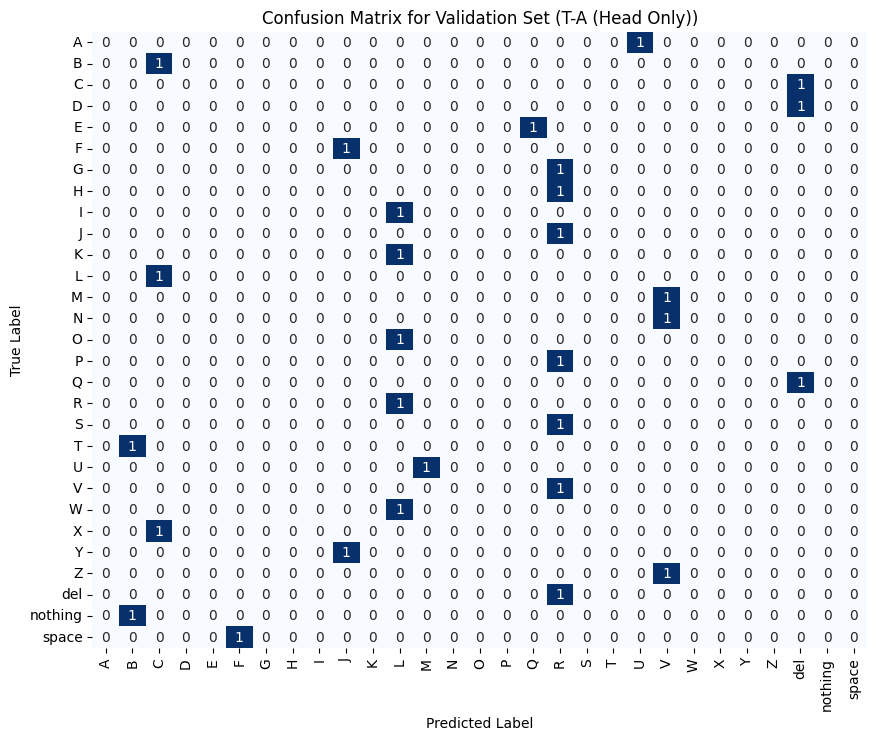

C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Results for Validation Set (T-B (L4+Head)) ---
  Accuracy: 0.2414
  Macro-F1: 0.1831


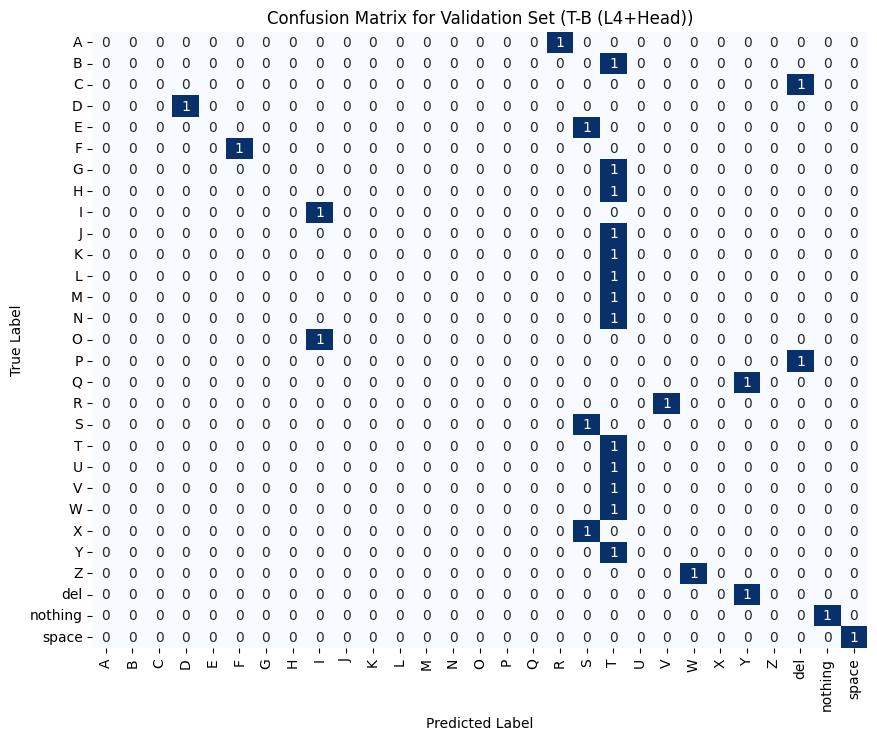

C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Results for Validation Set (T-C (L3+L4+Head)) ---
  Accuracy: 0.0690
  Macro-F1: 0.0460


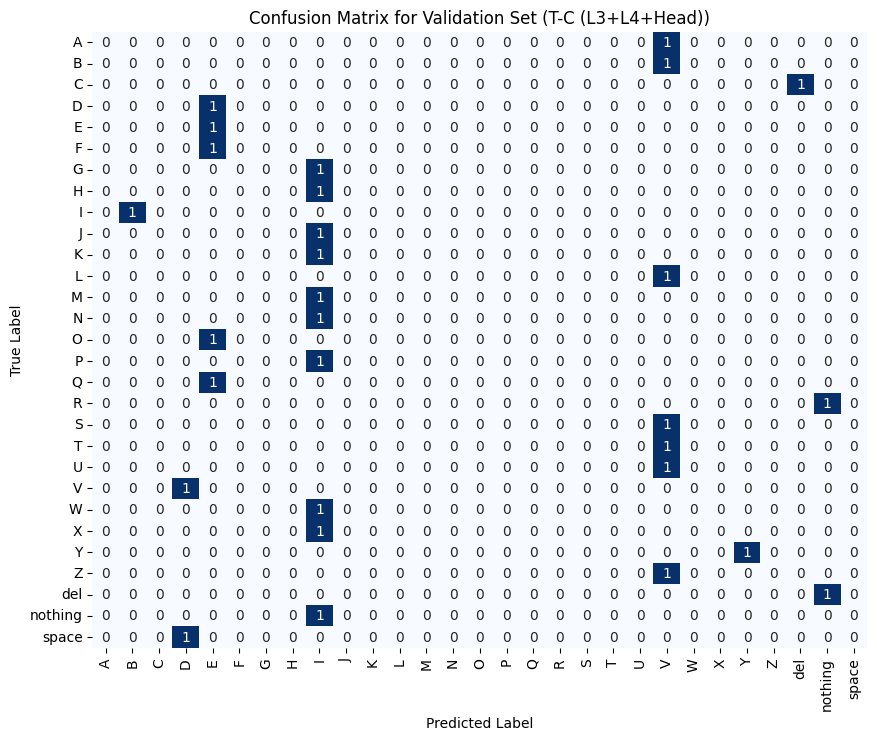

C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Results for Validation Set (S-A (Full FT)) ---
  Accuracy: 0.1034
  Macro-F1: 0.0559


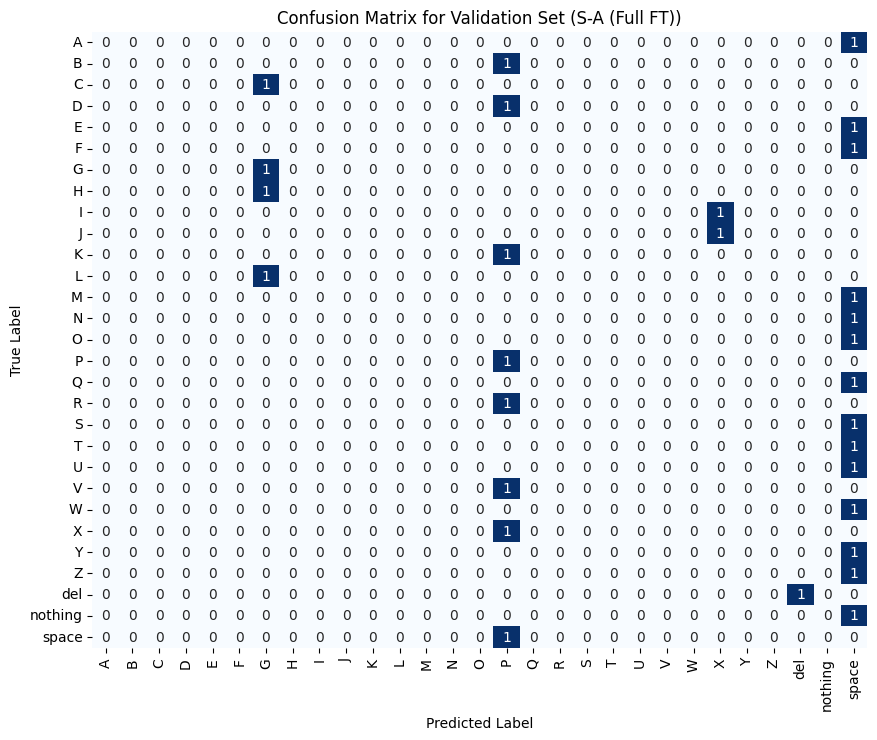


Model Selection Complete:
The best model based on Validation Macro-F1 is: **T-B (L4+Head)**
Best Macro-F1: 0.1831


In [31]:
MODEL_CHECKPOINTS = {
    "T-A (Head Only)": 'TA_HeadOnly_best.pth',
    "T-B (L4+Head)": 'TB_L4Head_best.pth',
    "T-C (L3+L4+Head)": 'TC_L34Head_best.pth',
    "S-A (Full FT)": 'SA_FullFT_best.pth',
}

best_overall_f1 = -1.0
best_model_id = None
best_checkpoint_path = None
results = {}

print("--- 1. MODEL SELECTION: VALIDATION MACRO-F1 ---")
for model_id, path in MODEL_CHECKPOINTS.items():
    if not os.path.exists(path):
        print(f"Skipping {model_id}: Checkpoint not found at {path}")
        continue
    
    # Load model weights
    model.load_state_dict(torch.load(path))
    
    # Evaluate on Validation Set
    val_acc, val_f1 = evaluate_full_metrics(
        model, 
        val_loader, 
        f"Validation Set ({model_id})", 
        val_ds.classes
    )
    
    results[model_id] = {'Accuracy': val_acc, 'Macro-F1': val_f1}
    
    if val_f1 > best_overall_f1:
        best_overall_f1 = val_f1
        best_model_id = model_id
        best_checkpoint_path = path

print("\n" + "="*50)
print(f"Model Selection Complete:")
print(f"The best model based on Validation Macro-F1 is: **{best_model_id}**")
print(f"Best Macro-F1: {best_overall_f1:.4f}")
print("="*50)

### 28 Image Kaggle Test Set

In [ ]:
# Loading the Data

try:
    # 1. Determine the parent path (e.g., .../versions/1/)
    # This step is correct: it navigates up two levels from the training data folder.
    train_parent_path = os.path.dirname(os.path.dirname(data_dir))
    
    # 2. CORRECTED PATH CONSTRUCTION: Remove the redundant final folder name.
    # The class folders (A, B, C...) are likely directly inside this folder.
    TEST_FOLDER_NAME = "asl_alphabet_test" 
    test_data_dir = os.path.join(train_parent_path, TEST_FOLDER_NAME)
    
    # 3. Load the full test dataset using the validation transforms (val_tf)
    full_test_source = datasets.ImageFolder(root=test_data_dir, transform=val_tf)

    # 4. Limit to the first 28 images for the required evaluation
    TEST_LIMIT = 28
    test_indices_28 = list(range(TEST_LIMIT)) 
    test_ds_28 = Subset(full_test_source, test_indices_28)

    # 5. Set classes and create the DataLoader
    test_ds_28.classes = raw_dataset.classes 

    test_loader_28 = DataLoader(
        test_ds_28, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    print(f"✅ Prepared Held-Out Test Set from '{test_data_dir}' with size: {len(test_ds_28)} images.")

except Exception as e:
    print(f"❌ Error setting up test data: {e}")
    test_loader_28 = None

# --- You would then proceed with Model Selection and Evaluation as before ---

✅ Prepared Held-Out Test Set from 'C:\Users\Vedh\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1\asl_alphabet_test' with size: 28 images.


In [ ]:
# --- 1. MODEL SELECTION (Identify the Best Checkpoint) ---

MODEL_CHECKPOINTS = {
    # Checkpoint names created during the Grid Search
    "T-A (Head Only)": 'TA_HeadOnly_best.pth',
    "T-B (L4+Head)": 'TB_L4Head_best.pth',
    "T-C (L3+L4+Head)": 'TC_L34Head_best.pth',
    "S-A (Full FT)": 'SA_FullFT_best.pth',
}

best_overall_f1 = -1.0
best_model_id = None
best_checkpoint_path = None

print("\n--- MODEL SELECTION: Re-evaluating checkpoints on Validation Set ---")

# Re-initialize a clean ResNet-18 model to load weights into for comparison
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

for model_id, path in MODEL_CHECKPOINTS.items():
    if not os.path.exists(path):
        print(f"Skipping {model_id}: Checkpoint not found at {path}")
        continue
    
    # Load the best weights found during the Grid Search for this model_id
    # map_location=DEVICE ensures the weights load correctly regardless of where they were saved (CPU/GPU)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    
    # Use the F1 metric helper to get the final score for model selection
    val_acc, val_f1 = evaluate_macro_f1(model, val_loader)
    
    print(f"  {model_id} (Val): Acc={val_acc:.4f}, F1={val_f1:.4f}")

    if val_f1 > best_overall_f1:
        best_overall_f1 = val_f1
        best_model_id = model_id
        best_checkpoint_path = path

print("\n" + "="*50)
print(f"Selected Best Model: **{best_model_id}** (F1: {best_overall_f1:.4f})")
print("="*50)


--- MODEL SELECTION: Re-evaluating checkpoints on Validation Set ---


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  T-A (Head Only) (Val): Acc=0.0000, F1=0.0000


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  T-B (L4+Head) (Val): Acc=0.2414, F1=0.1831


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  T-C (L3+L4+Head) (Val): Acc=0.0690, F1=0.0460


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  S-A (Full FT) (Val): Acc=0.1034, F1=0.0559

Selected Best Model: **T-B (L4+Head)** (F1: 0.1831)



--- FINAL EVALUATION: HELD-OUT 28-IMAGE TEST SET ---


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique clas


--- Results for FINAL TEST SET (Model: T-B (L4+Head)) ---
  Accuracy: 0.0000
  Macro-F1: 0.0000


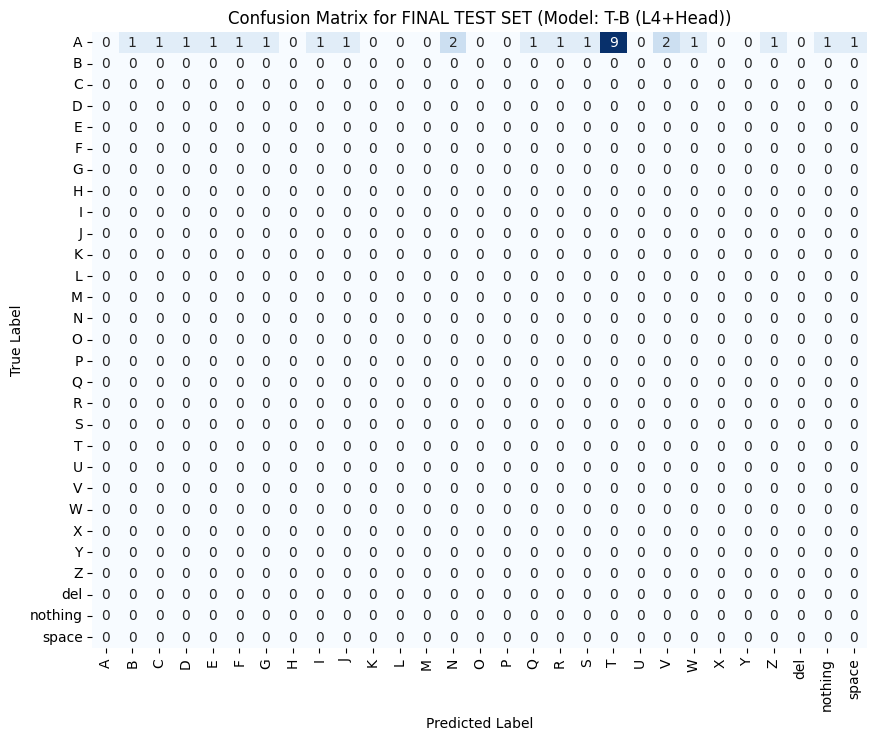


Final Test Metrics Summary:
  Accuracy: 0.0000
  Macro-F1: 0.0


In [37]:
## 2. FINAL EVALUATION on Held-Out Test Set

if best_checkpoint_path and test_loader_28:
    # Load the single best checkpoint
    model.load_state_dict(torch.load(best_checkpoint_path, map_location=DEVICE))
    
    print("\n--- FINAL EVALUATION: HELD-OUT 28-IMAGE TEST SET ---")
    
    # Evaluate exactly once using the full metrics function (includes Accuracy, Macro-F1, and CM plot)
    test_acc, test_f1 = evaluate_full_metrics(
        model, 
        test_loader_28, 
        f"FINAL TEST SET (Model: {best_model_id})", 
        test_ds_28.classes
    )
    
    print("\nFinal Test Metrics Summary:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  Macro-F1: {test_f1}")
    
else:
    print("\nERROR: Final evaluation skipped due to missing best model checkpoint.")